# ***KELOMPOK 4***
- Adam Toyib Nur Wahid / 442023611073
- Fayshal Karan Athilla / 442023611088
- Andrian Maulana / 442023611059
- Ahmad Irhan Fauzi / 442023611061
- Daffa Rafly Muhammad / 442023611063
- Muhammad Dwi Apriansyah / 442023611065

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import struct
from PIL import Image

# DATASET

In [2]:
class MNISTDataset(Dataset):
    def __init__(self, images_path, labels_path, image_size=28):
        self.images_path = images_path
        self.labels_path = labels_path
        self.image_size = image_size

        self.images = self._read_images(self.images_path)
        self.labels = self._read_labels(self.labels_path)

        self.transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

    def _read_images(self, filepath):
        with open(filepath, 'rb') as f:
            magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
            images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, 28, 28)
        return images

    def _read_labels(self, filepath):
        with open(filepath, 'rb') as f:
            magic, num = struct.unpack(">II", f.read(8))
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = Image.fromarray(image, mode='L')

        if self.transform:
            image = self.transform(image)

        return image, label

# MODEL

In [3]:
class MnistClassifier(nn.Module):

	def __init__(self, num_classes=10):
		super(MnistClassifier, self).__init__()

		self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
		self.pool = nn.MaxPool2d(2, 2)

		self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
		self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

		self.fc1 = nn.Linear(64 * 3 * 3, 64)
		self.fc2 = nn.Linear(64, num_classes)

	def forward(self, x):
		x = self.conv1(x)
		x = F.relu(x)
		x = self.pool(x)

		x = self.conv2(x)
		x = F.relu(x)
		x = self.pool(x)

		x = self.conv3(x)
		x = F.relu(x)
		x = self.pool(x)

		x = x.view(x.size(0), -1)
		x = self.fc1(x)
		x = F.relu(x)

		x = self.fc2(x)

		return x

# PERSIAPAN TRAINING

In [4]:
import argparse
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt


train_dataset = MNISTDataset(
    images_path='/kaggle/input/mnist-dataset/train-images.idx3-ubyte',
    labels_path='/kaggle/input/mnist-dataset/train-labels.idx1-ubyte'
)

test_dataset = MNISTDataset(
    images_path='/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte',
    labels_path='/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte'
)

batch_size = 16
test_batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 10

model = MnistClassifier(num_classes)
model = model.to(device)

In [5]:
# ini adalah fungsi loss
criterion = nn.CrossEntropyLoss()

# algoritma optimasi
# gradient descent
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

In [6]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 60874
Trainable parameters: 60874


In [8]:
train_losses = []
test_losses = []

epochs = 10
output_path = '/kaggle/working/model.pth'

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for data, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item() * data.size(0)

    model.eval()
    correct = 0
    total = 0
    test_loss = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * data.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    avg_train_loss = train_loss / len(train_dataset)
    avg_test_loss = test_loss / len(test_dataset)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f}, Test Loss {avg_test_loss:.4f}, Test Acc {acc:.4f}")

torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses,
    'test_loss': test_losses,
}, output_path)


Epoch 1: 100%|██████████| 3750/3750 [00:18<00:00, 197.93it/s]


Epoch 1: Train Loss 0.0185, Test Loss 0.0299, Test Acc 0.9901


Epoch 2: 100%|██████████| 3750/3750 [00:19<00:00, 195.77it/s]


Epoch 2: Train Loss 0.0166, Test Loss 0.0326, Test Acc 0.9901


Epoch 3: 100%|██████████| 3750/3750 [00:19<00:00, 194.27it/s]


Epoch 3: Train Loss 0.0149, Test Loss 0.0276, Test Acc 0.9911


Epoch 4: 100%|██████████| 3750/3750 [00:19<00:00, 197.22it/s]


Epoch 4: Train Loss 0.0137, Test Loss 0.0281, Test Acc 0.9912


Epoch 5: 100%|██████████| 3750/3750 [00:19<00:00, 195.39it/s]


Epoch 5: Train Loss 0.0123, Test Loss 0.0333, Test Acc 0.9895


Epoch 6: 100%|██████████| 3750/3750 [00:19<00:00, 195.41it/s]


Epoch 6: Train Loss 0.0107, Test Loss 0.0291, Test Acc 0.9903


Epoch 7: 100%|██████████| 3750/3750 [00:18<00:00, 198.97it/s]


Epoch 7: Train Loss 0.0098, Test Loss 0.0313, Test Acc 0.9901


Epoch 8: 100%|██████████| 3750/3750 [00:19<00:00, 197.14it/s]


Epoch 8: Train Loss 0.0088, Test Loss 0.0277, Test Acc 0.9917


Epoch 9: 100%|██████████| 3750/3750 [00:19<00:00, 196.48it/s]


Epoch 9: Train Loss 0.0080, Test Loss 0.0252, Test Acc 0.9928


Epoch 10: 100%|██████████| 3750/3750 [00:18<00:00, 197.67it/s]


Epoch 10: Train Loss 0.0064, Test Loss 0.0276, Test Acc 0.9921


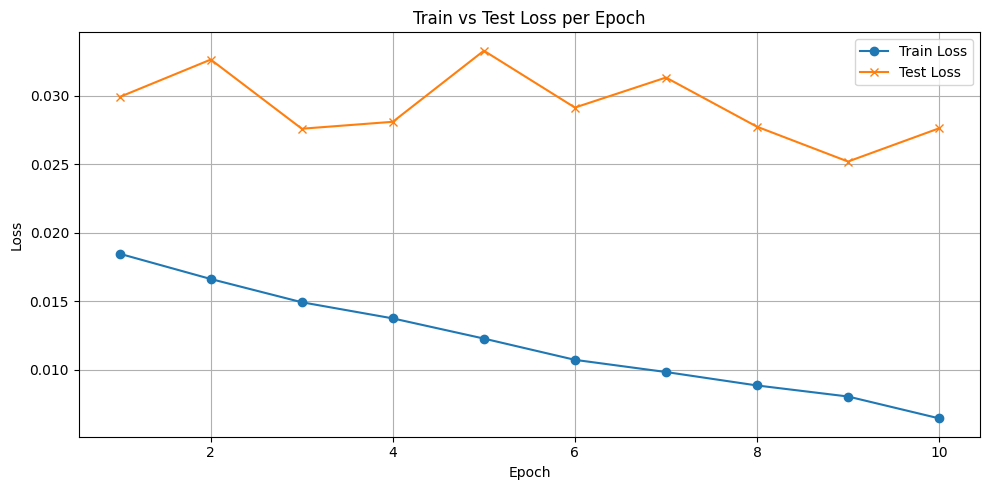

In [9]:

epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, test_losses, label='Test Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()